# Playing with new 2017 `tf.contrib.seq2seq`

I just discovered that a [new dynamic seq2seq implementation](https://github.com/tensorflow/tensorflow/tree/24466c2e6d32621cd85f0a78d47df6eed2c5c5a6/tensorflow/contrib/seq2seq) was recently merged into master. Naturally, I wanted to try it out.

`Working with commit 24466c2e6d32621cd85f0a78d47df6eed2c5c5a6`

In [1]:
import numpy as np
import tensorflow as tf
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [2]:
tf.__version__

'1.0.0-alpha'

In [3]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 3
decoder_hidden_units = encoder_hidden_units * 2

Everything is time-major

In [4]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')

decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
decoder_targets_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='decoder_targets_length')

During training, `decoder_targets` would serve as basis for both `decoder_inputs` and decoder logits. This means that their shapes should be compatible.

Here we do a bit of plumbing to set this up.

In [5]:
sequence_size, batch_size = tf.unstack(tf.shape(decoder_targets))

EOS_SLICE = tf.ones([1, batch_size], dtype=tf.int32)
PAD_SLICE = tf.zeros([1, batch_size], dtype=tf.int32)

decoder_train_inputs = tf.concat_v2([EOS_SLICE, decoder_targets], axis=0)
decoder_train_length = decoder_targets_length + 1

decoder_train_targets = tf.concat_v2([decoder_targets, PAD_SLICE], axis=0)
decoder_train_targets_seqlen, _ = tf.unstack(tf.shape(decoder_train_targets))
decoder_train_targets_eos_mask = tf.transpose(tf.one_hot(decoder_train_length - 1, decoder_train_targets_seqlen, dtype=tf.int32), [1, 0])
decoder_train_targets = tf.add(
    decoder_train_targets,
    decoder_train_targets_eos_mask,
)  # hacky way to put EOS symbol at the end of target sequence

loss_weights = tf.ones([batch_size, tf.reduce_max(decoder_train_length)], dtype=tf.float32, name="loss_weights")

In [6]:
# oh=tf.one_hot(decoder_train_length, decoder_train_targets_seqlen, dtype=tf.int32)

# sess.run([oh, decoder_train_targets_eos_mask], fd)

In [7]:
from tensorflow.contrib.rnn import (LSTMCell, LSTMStateTuple, EmbeddingWrapper)
import tensorflow.contrib.seq2seq as seq2seq

## Embedding

In [8]:
import math
from tensorflow.contrib.layers import embedding_lookup_unique

def embedding(inputs, embedding_classes, embedding_size, scope=None):
    with tf.variable_scope(scope) as scope:

        # Uniform(-sqrt(3), sqrt(3)) has variance=1.
        sqrt3 = math.sqrt(3)
        initializer = tf.random_uniform_initializer(-sqrt3, sqrt3)
        
        embedding_values = tf.get_variable(
            name="embedding",
            shape=[embedding_classes, embedding_size],
            initializer=initializer,
            dtype=tf.float32)
        
        return embedding_lookup_unique(embedding_values, inputs)

with tf.variable_scope("embedding") as scope:
    encoder_inputs_embedded = embedding(encoder_inputs,
                                        vocab_size,
                                        input_embedding_size,
                                        scope)
    
    scope.reuse_variables()

    decoder_train_inputs_embedded = embedding(decoder_train_inputs,
                                              vocab_size,
                                              input_embedding_size,
                                              scope)
    
    # we'll need matrix for inference
    embedding_matrix = tf.get_variable("embedding")

## Encoder

In [9]:
with tf.variable_scope("Encoder") as scope:
    encoder_cell = LSTMCell(encoder_hidden_units)
    
    ((encoder_fw_outputs,
      encoder_bw_outputs),
     (encoder_fw_state,
      encoder_bw_state)) = (
        tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                        cell_bw=encoder_cell,
                                        inputs=encoder_inputs_embedded,
                                        sequence_length=encoder_inputs_length,
                                        dtype=tf.float32, time_major=True, scope=scope)
        )

    encoder_outputs = tf.concat_v2((encoder_fw_outputs, encoder_fw_outputs), 2)

    encoder_state_c = tf.concat_v2(
        (encoder_fw_state.c, encoder_bw_state.c), 1)

    encoder_state_h = tf.concat_v2(
        (encoder_fw_state.h, encoder_bw_state.h), 1)

    encoder_state = LSTMStateTuple(
        c=encoder_state_c,
        h=encoder_state_h
    )

## Decoder

#### Training

In [10]:
decoder_cell = LSTMCell(decoder_hidden_units)

with tf.variable_scope("Decoder") as scope:
    decoder_fn_train = seq2seq.simple_decoder_fn_train(encoder_state=encoder_state)
    
    (
        decoder_outputs_train,
        decoder_state_train,
        decoder_context_state_train
    ) = (
        seq2seq.dynamic_rnn_decoder(
           cell=decoder_cell,
           decoder_fn=decoder_fn_train,
           inputs=decoder_train_inputs_embedded,
           sequence_length=decoder_train_length,
           time_major=True,
           scope=scope,
        )
    )
    
    def output_fn(outputs):
        return tf.contrib.layers.linear(outputs, vocab_size, scope=scope)
    
    decoder_logits_train = output_fn(decoder_outputs_train)
    
    decoder_prediction_train = tf.argmax(decoder_logits_train, axis=-1, name='decoder_prediction')
    
    scope.reuse_variables()
    
    decoder_fn_inference = seq2seq.simple_decoder_fn_inference(
        output_fn=output_fn,
        encoder_state=encoder_state,
        embeddings=embedding_matrix,
        start_of_sequence_id=1,
        end_of_sequence_id=1,
        maximum_length=tf.reduce_max(encoder_inputs_length) + 3,
        num_decoder_symbols=vocab_size,
    )
    
    (
        decoder_outputs_inference,
        decoder_state_inference,
        decoder_context_state_inference
    ) = (
        seq2seq.dynamic_rnn_decoder(
           cell=decoder_cell,
           decoder_fn=decoder_fn_inference,
           time_major=True,
           scope=scope,
        )
    )
    
    ## @TODO: in case of inference decoder_outputs_inference is logits, not cell_output?


seqloss = seq2seq.sequence_loss(
    logits=tf.transpose(decoder_logits_train, [1, 0, 2]),
    targets=tf.transpose(decoder_train_targets, [1, 0]),
    weights=loss_weights)

loss = tf.reduce_mean(seqloss)
train_op = tf.train.AdamOptimizer().minimize(loss)

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training

In [11]:
sess.run(tf.global_variables_initializer())

In [12]:
import helpers

In [13]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

seq = next(batches)[0]
print(seq)

[6, 9, 5]


In [14]:
def next_feed():
    batch = next(batches)
    inputs_, inputs_length_ = helpers.batch(batch)
    return {
        encoder_inputs: inputs_,
        encoder_inputs_length: inputs_length_,
        decoder_targets: inputs_,
        decoder_targets_length: inputs_length_,
    }

In [15]:
loss_track = []

In [16]:
for k, v in next_feed().items():
    print(k, len(v))

Tensor("encoder_inputs:0", shape=(?, ?), dtype=int32) 8
Tensor("encoder_inputs_length:0", shape=(?,), dtype=int32) 100
Tensor("decoder_targets:0", shape=(?, ?), dtype=int32) 8
Tensor("decoder_targets_length:0", shape=(?,), dtype=int32) 100


In [17]:
encoder_outputs

<tf.Tensor 'Encoder/concat_v2:0' shape=(?, ?, 6) dtype=float32>

In [21]:
max_batches = 10000
batches_in_epoch = 1000

def transpose(l):
    return [x.T for x in l]

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            for i, (e_in, d_tg, dt_in, dt_tg, dt_pred) in enumerate(zip(
                    fd[encoder_inputs].T, 
                    fd[decoder_targets].T,
                    *transpose(sess.run([
                        decoder_train_inputs,
                        decoder_train_targets,
                        decoder_prediction_train,
                    ], fd))
                )):
                print('  sample {}:'.format(i + 1))
                print('    enc input           > {}'.format(e_in))
                #print('    dec target          > {}'.format(d_tg))
                #print('    dec train input     > {}'.format(dt_in))
                #print('    dec train target    > {}'.format(dt_tg))
                print('    dec train predicted > {}'.format(dt_pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 0.33455735445022583
  sample 1:
    enc input           > [6 5 6 3 2 7 0 0]
    dec train predicted > [6 6 6 3 2 7 1 0 0]
  sample 2:
    enc input           > [2 7 2 8 0 0 0 0]
    dec train predicted > [2 7 2 8 1 0 0 0 0]
  sample 3:
    enc input           > [3 7 8 9 7 4 4 0]
    dec train predicted > [7 7 8 7 7 4 4 1 0]

batch 1000
  minibatch loss: 0.28174811601638794
  sample 1:
    enc input           > [7 3 6 9 6 4 6 3]
    dec train predicted > [3 6 6 6 6 3 6 3 1]
  sample 2:
    enc input           > [6 9 6 0 0 0 0 0]
    dec train predicted > [6 9 6 1 0 0 0 0 0]
  sample 3:
    enc input           > [7 7 8 3 2 8 8 0]
    dec train predicted > [7 7 8 3 8 8 8 1 0]

batch 2000
  minibatch loss: 0.27828481793403625
  sample 1:
    enc input           > [9 5 5 6 9 7 0 0]
    dec train predicted > [9 5 5 9 9 7 1 0 0]
  sample 2:
    enc input           > [5 2 5 9 0 0 0 0]
    dec train predicted > [5 2 5 9 1 0 0 0 0]
  sample 3:
    enc input           > 

loss 0.2038 after 2000000 examples (batch_size=100)


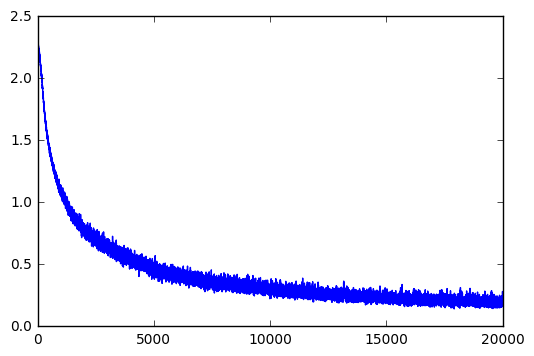

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'\
      .format(loss_track[-1], len(loss_track)*batch_size,
              batch_size))